# Projeto 2 - Desenvolvimento de um Alpha Zero capaz de jogar jogos

## Introdução

O segundo projeto proposto para a unidade curricular de Laboratórios de Inteligência Artificial e Ciência de Dados consiste na criação de um algoritmo Alpha Zero capaz de jogar 2 jogos, Attax e Go, sendo testados em diferentes cenários. No caso do Attax, tabuleiro 4x4, 6x6, e tamanho variável(5x5), enquanto no Go tamanho de 7x7 e 9x9.

## Jogos implementados

#### Attax:
O Attax é um jogo de estratégia de tabuleiro abstrato de dois jogadores, que consiste em tentar fazer com que no final do jogo a maioria das peças do tabuleiro sejam do jogador, convertendo a maioria das peças do oponente possiveis.
Geralmente, o jogo começa com 2 peças para cada jogador, cada uma nos cantos do tabuleiro.


#### Go:
O Go também é um jogo de estratégia de tabuleiro, em que o objetivo é capturar, isto é, rodear mais território que o adversário, sendo considerado o jogo de tabuleiro jogado de forma contínua há mais tempo.
O jogo usa peças pretas e brancas colocadas em posições livres no tabuleiro, sendo que o jogador que começa em segundo recebe pontos extra devido a essa desvantagem.



## Bibliotecas utilizadas



- numpy
- pygame
- torch


## Implementação dos jogos

## Go

### Código da implementação:

In [4]:
import numpy as np


class Go():
    EMPTY = 0
    BLACK = 1
    WHITE = -1
    BLACKMARKER = 4
    WHITEMARKER = 5
    LIBERTY = 8

    def __init__(self, small_board=True):
        self.row_count = 7 if small_board else 9
        self.column_count = 7 if small_board else 9
        self.board_size = 7 if small_board else 9
        self.komi = 5.5
        self.action_size = self.row_count * self.column_count + 1
        self.liberties = []
        self.name="Go"
        self.block = []
        self.seki_count = 0
        self.seki_liberties = []
        self.state_history = [self.get_initial_state()]
        self.currrent_player = self.BLACK
        self.passed_player_1 = False
        self.passed_player_2 = False


    def get_initial_state(self):
        board = np.zeros((self.row_count, self.column_count))
        self.state_history = [np.copy(board)]
        return board

    def count(self, x, y, state: list, player: int, liberties: list, block: list):


        # initialize piece
        piece = state[y][x]
        # if there's a stone at square of the given player
        if piece == player:
            # save stone coords
            block.append((y, x))
            # mark the stone
            if player == self.BLACK:
                state[y][x] = self.BLACKMARKER
            else:
                state[y][x] = self.WHITEMARKER

            # look for neighbours recursively
            if y - 1 >= 0:
                liberties, block = self.count(x, y - 1, state, player, liberties, block)  # walk north
            if x + 1 < self.column_count:
                liberties, block = self.count(x + 1, y, state, player, liberties, block)  # walk east
            if y + 1 < self.row_count:
                liberties, block = self.count(x, y + 1, state, player, liberties, block)  # walk south
            if x - 1 >= 0:
                liberties, block = self.count(x - 1, y, state, player, liberties, block)  # walk west

        # if square is empty
        elif piece == self.EMPTY:
            # mark liberty
            state[y][x] = self.LIBERTY
            # save liberties
            liberties.append((y, x))

        # print("Liberties: " + str(len(self.liberties)) + " in: " + str(x) + "," + str(y))
        # print("Block: " + str(len(self.block)) + " in: " + str(x) + "," + str(y))
        return liberties, block

    # remove captured stones
    def clear_block(self, block: list, state: list) -> list:


        # clears the elements in the block of elements which is captured
        for i in range(len(block)):
            y, x = block[i]
            state[y][x] = self.EMPTY

        return state

    # restore board after counting stones and liberties

    def get_current_state(self):
        return self.state_history[-1]
    def restore_board(self, state: list) -> list:

        for y in range(len(state)):
            for x in range(len(state)):
                # restore piece
                val = state[y][x]
                if val == self.BLACKMARKER:
                    state[y][x] = self.BLACK
                elif val == self.WHITEMARKER:
                    state[y][x] = self.WHITE
                elif val == self.LIBERTY:
                    state[y][x] = self.EMPTY

        # print("After Restore Board")
        # print(state)
        return state

    def print_board(self, state) -> None:

        print("   ", end="")
        for j in range(self.column_count):
            print(f"{j:2}", end=" ")
        print("\n  +", end="")
        for _ in range(self.column_count):
            print("---", end="")
        print()

        for i in range(self.row_count):
            print(f"{i:2}|", end=" ")
            for j in range(self.column_count):
                print(f"{str(int(state[i][j])):2}", end=" ")
            print()

    def captures(self, state: list, player: int, a: int, b: int):

        check = False
        neighbours = []
        if (a > 0): neighbours.append((a - 1, b))
        if (a < self.column_count - 1): neighbours.append((a + 1, b))
        if (b > 0): neighbours.append((a, b - 1))
        if (b < self.row_count - 1): neighbours.append((a, b + 1))

        # loop over the board squares
        for pos in neighbours:
            # print(pos)
            x = pos[0]
            y = pos[1]
            # init piece
            piece = state[x][y]

            # if stone belongs to given colour
            if piece == player:
                # print("opponent piece")
                # count liberties
                liberties = []
                block = []
                liberties, block = self.count(y, x, state, player, liberties, block)
                # print("Liberties in count: " + str(len(liberties)))
                # if no liberties remove the stones
                if len(liberties) == 0:
                    # clear block

                    state = self.clear_block(block, state)

                    # if the move is a "ko" move but causes the capture of stones, then it is not allowed, unless it is the second move, in which case it is dealt afterwards
                    if self.seki_count == 0:
                        # print("Seki Found")
                        # returns False, which means that the move has caused a capture (the logic worked out that way in the initial development and i'm not sure what it would affect if it is changed)
                        check = True
                        self.seki_count = 1
                        continue
                # restore the board
                state = self.restore_board(state)
        # print("Seki Count: " + str(self.seki_count))
        return check, state




    def set_stone(self, a, b, state, player):
        state[a][b] = player
        return state

    def get_next_state_mcts(self, state, action, player):

        if action == self.row_count * self.column_count:
            if self.passed_player_1:
                self.passed_player_2 = True
            else:
                self.passed_player_1 = True
            return state # pass move

        a = action // self.row_count
        b = action % self.column_count

        state_copy = np.copy(state)
        state[a][b] = player
        state = self.captures(state, -player, a, b)[1]
        self.passed_player_1 = False
        self.passed_player_2 = False

        self.state_history.append(np.copy(state_copy))

        return state

    def get_next_state(self, state, action, player):

        if action == self.row_count * self.column_count:
            return state # pass move

        a = action // self.row_count
        b = action % self.column_count

        state_copy = np.copy(state)
        state[a][b] = player
        state = self.captures(state, -player, a, b)[1]

        self.state_history.append(np.copy(state_copy))

        return state

    # Dentro da classe Go

    def is_valid_move(self, state: list, action: tuple, player: int) -> bool:
        a, b = action[0], action[1]  # Mantenha as coordenadas originais
        state_copy = np.copy(state).astype(np.int8)

        if len(self.state_history) > 1:
            if np.array_equal(state, self.state_history[-2]):
                #print("Ko violation")
                return False

        # Restante do código permanece inalterado
        if a < 0 or a >= self.row_count or b < 0 or b >= self.column_count:
            #print("Invalid move: Out of bounds")
            return False

        if state[a][b] != self.EMPTY:
            #print("Space Occupied")
            return False

        state_copy = self.set_stone(a, b, state_copy, player)

        if self.captures(state_copy, -player, a, b)[0] == True:
            return True
        else:
            libs, block = self.count(b, a, state_copy, player, [], [])
            if len(libs) == 0:
                #print("Invalid move: Suicide")
                return False
            else:
                return True

    def get_valid_moves(self, state, player):

        newstate = np.zeros((self.row_count, self.column_count))
        for a in range(0, self.column_count):
            for b in range(0, self.row_count):
                if self.is_valid_move(state, (a, b), player):
                    newstate[a][b] = 1

        newstate = newstate.reshape(-1)
        newstate = np.concatenate([newstate, [1]])
        return (newstate).astype(np.uint8)

    def get_value_and_terminated(self, state, player):

        '''
        # Description:
        Returns the value of the state and if the game is over.
        '''

        scoring, endgame = self.scoring(state)

        if self.passed_player_1 and self.passed_player_2:
            endgame=True

        if endgame:
            if scoring > 0:
                return 1, True
            else:
                return -1, True
        else:
            if scoring > 0:
                return 1, False
            else:
                return -1, False


    def scoring(self, state):
        '''
        # Description:
        Checks the score of the game.
        '''
        black = 0
        white = 0
        empty = 0
        endgame = False
        # print("Scoring")
        for x in range(self.column_count):
            for y in range(self.row_count):
                if state[x][y] == self.EMPTY:
                    empty += 1
                    if empty >= self.column_count * self.row_count // 5: # if more than 1/4 of the board is empty, it is not the endgame
                        endgame = False

        black, white = self.count_influenced_territory_enhanced(state)

        return black - (white + self.komi), endgame


    def count_influenced_territory_enhanced(self, board):
        black_territory = 0
        white_territory = 0
        visited = set()

        # Function to calculate influence score
        def influence_score(x, y):
            score = 0
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < len(board) and 0 <= ny < len(board[0]):
                    score += board[nx][ny]
            return score

        # Function to explore territory
        def explore_territory(x, y):
            nonlocal black_territory, white_territory
            if (x, y) in visited or not (0 <= x < len(board) and 0 <= y < len(board[0])):
                return
            visited.add((x, y))

            if board[x][y] == 0:
                score = influence_score(x, y)
                if score > 0:
                    black_territory += 1
                elif score < 0:
                    white_territory += 1

        for i in range(len(board)):
            for j in range(len(board[0])):
                if board[i][j] == 0 and (i, j) not in visited:
                    explore_territory(i, j)

        return black_territory, white_territory


    def get_opponent(self, player):
        return -player

    def get_opponent_value(self, value):
        return -value

    def get_encoded_state(self, state):
        layer_1 = np.where(np.array(state) == -1, 1, 0).astype(np.float32)
        layer_2 = np.where(np.array(state) == 0, 1, 0).astype(np.float32)
        layer_3 = np.where(np.array(state) == 1, 1, 0).astype(np.float32)

        result = np.stack([layer_1, layer_2, layer_3]).astype(np.float32)

        return result

    def change_perspective(self, state, player):
        return state * player




## Attax

In [ ]:
import numpy as np


class Attaxx:
    def __init__(self, args: tuple):
        self.column_count : int = args[0]
        self.row_count : int = args[1]
        self.name="Attaxx"
        self.action_size : int = (self.column_count * self.row_count) ** 2

    def clone(self):
        copia = Attaxx((self.row_count,self.column_count))

        return copia

    def get_initial_state(self):
        state = np.zeros((self.column_count, self.row_count))
        state[0][0] = 1
        state[self.column_count-1][self.row_count-1] = 1
        state[0][self.column_count-1] = -1
        state[self.row_count-1][0] = -1
        return state

    def get_next_state(self, state, action, player):
        move = self.int_to_move(action)
        a, b, a1, b1 = move[0], move[1], move[2], move[3]
        if abs(a-a1)==2 or abs(b-b1)==2:
            state[a][b] = 0
            state[a1][b1] = player
        else:
            state[a1][b1] = player
        self.capture_pieces(state, move, player)
        return state

    def is_valid_move(self, state, action, player):
        move = self.int_to_move(action)
        a, b, a1, b1 = move[0], move[1], move[2], move[3]
        if (a==a1 and b==b1):
            return False
        if abs(a-a1)>2 or abs(b-b1)>2 or state[a1][b1]!=0 or state[a][b]!=player :
            return False
        return True

    def capture_pieces(self, state, action, player):
        a, b, a1, b1 = action
        for i in range(a1-1, a1+2):
            for j in range(b1-1, b1+2):
                try:
                    if state[i][j]==-player and i>=0 and j>=0:
                        state[i][j] = player
                except IndexError:
                    pass
                continue

    def check_available_moves(self, state, player):
        for i in range(self.column_count):
            for j in range(self.row_count):
                if state[i][j] == player:
                    for a in range(self.column_count):
                        for b in range(self.row_count):
                            action = (i, j, a, b)
                            if self.is_valid_move(state, action, player):
                                return True
        return False

    def move_to_int(self, move):
        return move[3] + move[2]*self.column_count + move[1]*self.column_count**2 + move[0]*self.column_count**3

    def int_to_move(self, num):
        move = [(num // self.column_count**3) % self.column_count,
                (num // self.column_count**2) % self.column_count,
                (num // self.column_count) % self.column_count,
                num % self.column_count]
        return move


    def get_valid_moves(self, state, player):
        possible_moves = set()
        for i in range(self.row_count):
            for j in range(self.column_count):
                state[i][j] = int(state[i][j])
                if state[i][j] == player:
                    moves_at_point = set(self.get_moves_at_point(state, player, i, j))
                    possible_moves = possible_moves.union(moves_at_point)

        possible_moves_to_int = []
        for move in possible_moves:
            possible_moves_to_int.append(self.move_to_int(move))
        binary_representation = [1 if i in possible_moves_to_int else 0 for i in range(self.action_size)]

        return binary_representation





    def get_moves_at_point(self, state, player, a, b):
        moves_at_point = []
        for i in range(self.column_count):
            for j in range(self.row_count):
                possible_action = (a, b, i, j)
                tmp = self.move_to_int(possible_action)
                if self.is_valid_move(state, tmp, player):
                    moves_at_point.append(possible_action)
        return moves_at_point

    def check_board_full(self, state):
        for row in state:
            if 0 in row:
                return False

        return True



    def check_win_and_over(self, state, action):
        # action não é necessário para o attaxx, mas é necessário para o go

        count_player1 = 0
        count_player2 = 0

        player1Moves = self.get_valid_moves(state, player=1)
        player2Moves = self.get_valid_moves(state, player=-1)


        for i in range(self.column_count):
            for j in range(self.row_count):
                if state[i][j] == 1:
                    count_player1+=1
                elif state[i][j] == -1:
                    count_player2+=1
        if count_player1 == 0:
            return -1, True,count_player1,count_player2
        elif count_player2 == 0:
            return 1, True,count_player1,count_player2


        if not self.check_board_full(state):
            if max(player1Moves) == 0:
                return -1, True, count_player1, count_player2
            if max(player2Moves) == 0:
                return 1, True, count_player1, count_player2

        if self.check_board_full(state):
            if count_player1>count_player2:
                return 1, True,count_player1,count_player2
            elif count_player2>count_player1:
                return -1, True,count_player1,count_player2
            elif count_player1==count_player2:
                return 2, True,count_player1,count_player2

        return 0, False,count_player1,count_player2

    def get_value_and_terminated(self, state,player=None):
        winner, game_over, _, _ = self.check_win_and_over(state, action = None)
        return winner, game_over

    def print_board(self, state):
        state = state.astype(int)
        # Print column coordinates
        print("   ", end="")
        for j in range(len(state[0])):
            print(f"{j:2}", end=" ")
        print("\n  +", end="")
        for _ in range(len(state[0])):
            print("---", end="")
        print()

        # Print rows with row coordinates
        for i in range(len(state)):
            print(f"{i:2}|", end=" ")
            for j in range(len(state[0])):
                print(f"{str(state[i][j]):2}", end=" ")
            print()

    def get_encoded_state(self, state):
        layer_1 = np.where(np.array(state) == -1, 1, 0).astype(np.float32) #returns same sized board replacing all -1 with 1 and all other positions with 0
        layer_2 = np.where(np.array(state) == 0, 1, 0).astype(np.float32) #same logic for each possible number in position (-1, 1, or 0)
        layer_3 = np.where(np.array(state) == 1, 1, 0).astype(np.float32)

        result = np.stack([layer_1, layer_2, layer_3]).astype(np.float32) #encoded state

        return result

    def get_opponent(self, player):
        return -player

    def get_opponent_value(self, value):
        return -value

    def change_perspective(self, state, player):
        return state * player

### Implementação da interface

Visualização da interface implementada:

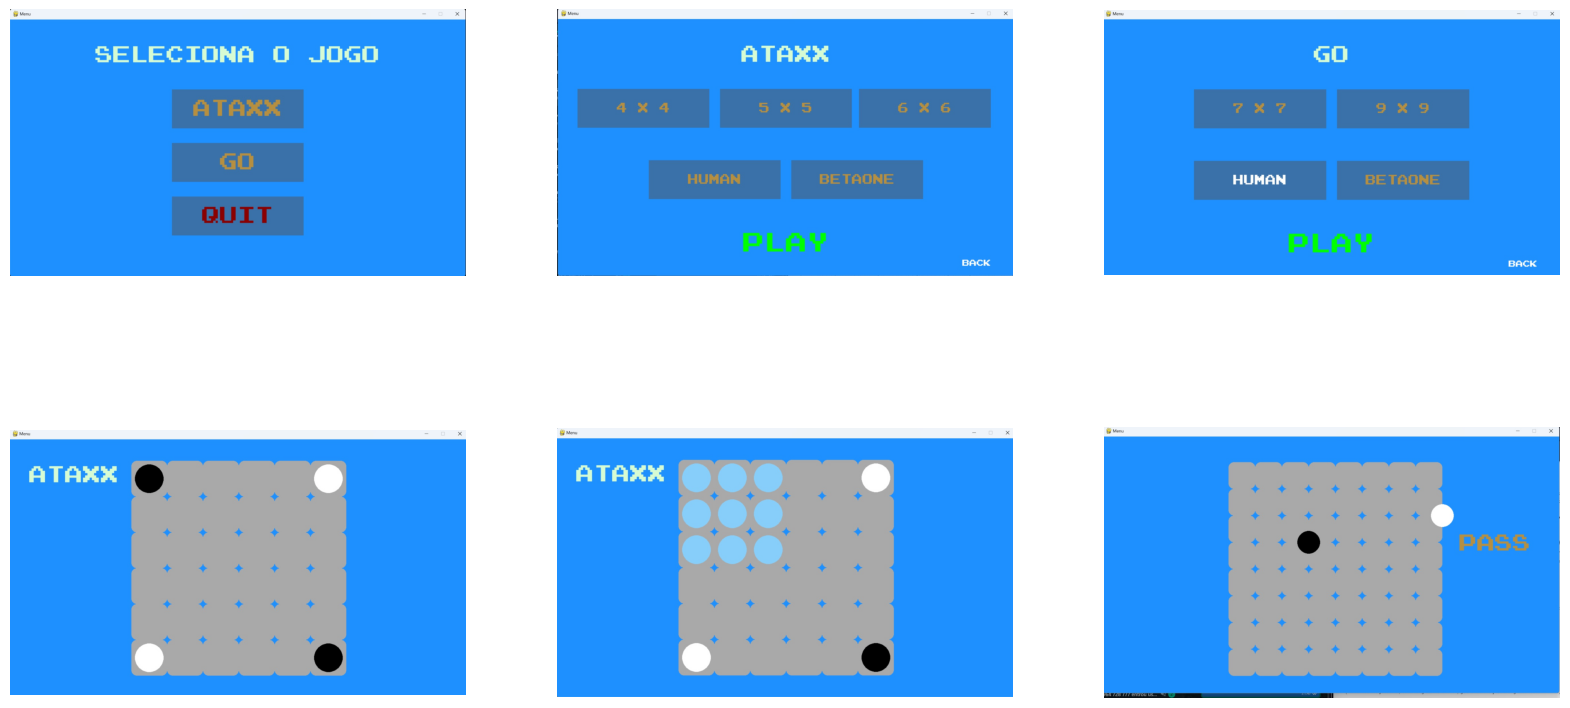

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

rcParams['figure.figsize'] = 20, 10  # Ajuste o tamanho da figura conforme necessário

img_A = mpimg.imread('menu.jfif')
img_B = mpimg.imread('attax.jfif')
img_C = mpimg.imread('go.jfif')
img_D = mpimg.imread('attax_board.jfif')
img_E = mpimg.imread('attax_possible.jfif')
img_F = mpimg.imread('go_board.jfif')

fig, ax = plt.subplots(2, 3)  # 2 linhas, 3 colunas

ax[0, 0].imshow(img_A)
ax[0, 1].imshow(img_B)
ax[0, 2].imshow(img_C)
ax[1, 0].imshow(img_D)
ax[1, 1].imshow(img_E)
ax[1, 2].imshow(img_F)

# Oculta os eixos
for a in ax.flatten():
    a.axis('off')

plt.show()


## Alphazero

In [ ]:
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from tqdm import trange

class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super().__init__()
        self.device = device

        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )

        self.to(device)

    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value

class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        self.children = []

        self.visit_count = visit_count
        self.value_sum = 0

    def is_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                copy_game = self.game.clone()
                child_state = self.state.copy()
                child_state = copy_game.get_next_state(child_state, action, 1)
                child_state = copy_game.change_perspective(child_state, player=-1)

                child = Node(copy_game, self.args, child_state, self, action, prob)
                self.children.append(child)

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        if self.parent is not None:
            value = self.game.get_opponent_value(value)
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self, model, game, args):
        self.model = model
        self.game = game
        self.args = args

    @torch.no_grad()
    def search(self, state, player):
        copy_game = self.game.clone()
        root = Node(copy_game, self.args, state, visit_count=1)

        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)

        valid_moves = root.game.get_valid_moves(state, player)
        if self.game.name == "Go":
            tmp = valid_moves[-1]
            valid_moves[-1] = 0
            if max(valid_moves) == 0:
                valid_moves[-1] = tmp
        policy *= valid_moves
        policy /= np.sum(policy)
        root.expand(policy)

        for search in range(self.args['num_mcts_searches']):
            node = root
            # print("A")
            while node.is_expanded():
                node = node.select()

            value, is_terminal = node.game.get_value_and_terminated(node.state,player)
            value = node.game.get_opponent_value(value)

            if not is_terminal:
                policy, value = self.model(torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = node.game.get_valid_moves(node.state, player)
                if self.game.name == "Go":
                    tmp = valid_moves[-1]
                    valid_moves[-1] = 0
                    if max(valid_moves) == 0:
                        valid_moves[-1] = tmp
                policy *= valid_moves
                policy /= np.sum(policy)

                value = value.item()

                node.expand(policy)
            # print("B")
            node.backpropagate(value)

        ac = self.game.action_size
        action_probs = np.zeros(ac)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        #print(np.argmax(action_probs))
        return action_probs

class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(model, game, args)

    def check_simmetries(self, state):
        rot90_state = np.rot90(state, k=1)
        rot90 = (state == rot90_state).all()

        rot180_state = np.rot90(state, k=2)
        rot180 = (state == rot180_state).all()

        rot270_state = np.rot90(state, k=3)
        rot270 = (state == rot270_state).all()

        flip_hori_state = np.fliplr(state)
        flip_hori = (state == flip_hori_state).all()

        flip_vert_state = np.flipud(state)
        flip_vert = (state == flip_vert_state).all()

        rot90_flip_hor_state = np.rot90(np.fliplr(state), k=1)
        rot90_flip_hor = (state == rot90_flip_hor_state).all()

        rot90_flip_vert_state = np.rot90(np.flipud(state), k=1)
        rot90_flip_vert = (state == rot90_flip_vert_state).all()

        return ((rot90, rot90_state), (rot180, rot180_state), (rot270, rot270_state),
                (flip_hori, flip_hori_state), (flip_vert, flip_vert_state),
                (rot90_flip_hor, rot90_flip_hor_state), (rot90_flip_vert, rot90_flip_vert_state))


    def augment_state(self, state):

        rot90, rot180, rot270, flip_hori, flip_vert, rot90_flip_hor, rot90_flip_vert = self.check_simmetries(state)

        augmented_states = []

        # Original state
        augmented_states.append(state)

        # Rotate 90 degrees clockwise
        if not rot90[0]:
            augmented_states.append(rot90[1])

        # Rotate 180 degrees clockwise
        if not rot180[0]:
            augmented_states.append(rot180[1])

        # Rotate 270 degrees clockwise
        if not rot270[0]:
            augmented_states.append(rot270[1])

        # Flip horizontally
        if not flip_hori[0]:
            augmented_states.append(flip_hori[1])

        # Flip vertically
        if not flip_vert[0]:
            augmented_states.append(flip_vert[1])

        # Rotate 90 degrees clockwise and flip horizontally
        if not rot90_flip_hor[0]:
            augmented_states.append(rot90_flip_hor[1])

        # Rotate 90 degrees clockwise and flip vertically
        if not rot90_flip_vert[0]:
            augmented_states.append(rot90_flip_vert[1])

        return augmented_states

    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()
        MAX_MOVES = 200
        count = 0
        while True:
            #self.game.print_board(state)
            count += 1

            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state, 1)

            memory.append((neutral_state, action_probs, player))

            temperature_action_probs = action_probs ** (1 / self.args['temperature'])
            temperature_action_probs /= np.sum(temperature_action_probs)

            ac = self.game.action_size
            #print(f"AC: {ac}, TMP size: {len(temperature_action_probs)}")
            action = np.random.choice(ac, p=temperature_action_probs)
            #print(f"Action selected: {action}")
            if self.game.name == 'Attaxx':
                state = self.game.get_next_state(state, action, player)
            else:
                state = self.game.get_next_state_mcts(state, action, player)

            value, is_terminal = self.game.get_value_and_terminated(state,player)
            #print(value)

            if count >= MAX_MOVES:
                #print("Max moves reached")
                is_terminal = True
                value = 2

            if is_terminal:
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    if self.args['augment']:
                        augmented_states = self.augment_state(hist_neutral_state)
                    else:
                        augmented_states = []
                        augmented_states.append(hist_neutral_state)

                    for augmented_state in augmented_states:
                        #print((augmented_state))
                        returnMemory.append((self.game.get_encoded_state(augmented_state), hist_action_probs, hist_outcome))

                return returnMemory

            player = self.game.get_opponent(player)

    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:batchIdx+self.args['batch_size']]
            state, policy_targets, value_targets = zip(*sample)

            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            out_policy, out_value = self.model(state)

            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []

            print(f"Iteration {iteration + 1}")
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()


            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            print("\n")

            torch.save(self.model.state_dict(), f"AlphaZero/Models/{self.args['alias']}/model.pt")
            torch.save(self.optimizer.state_dict(), f"AlphaZero/Models/{self.args['alias']}/optimizer.pt")

## Training

## Script para lidar com os argumentos:

In [ ]:
import json

def load_args_from_json(path, game_name, model_name):
    args = {}
    with open(f"{path}/args.json", "r") as openfile:
        print("\nLoading training and MCTS args from JSON file...")
        try:
            args = json.load(openfile)
            print("Args succefully loaded from file")
        except json.decoder.JSONDecodeError as e:
            print("JSON file is empty, args will take default values and will be saved as args.json")
            args = {
                'game': 'Attaxx',
                'num_iterations': 100,              # number of highest level iterations
                'num_selfPlay_iterations': 50,   # number of self-play games to play within each iteration
                'num_mcts_searches': 20,          # number of mcts simulations when selecting a move within self-play
                'num_epochs': 15,                  # number of epochs for training on self-play data for each iteration
                'batch_size': 500,                 # batch size for training
                'temperature': 1.0,              # temperature for the softmax selection of moves
                'C': 4,                           # the value of the constant policy
                'augment': False,                 # whether to augment the training data with flipped states
                'dirichlet_alpha': 0.3,           # the value of the dirichlet noise
                'dirichlet_epsilon': 0.125,       # the value of the dirichlet noise
                'alias': f'{game_name}_{model_name}'
            }
            save_args_to_json(args, path)

    return args

def save_args_to_json(args, path):
    with open(f"{path}/args.json", "w") as outfile:
        print("\nSaving training and MCTS args to JSON...")
        json.dump(args, outfile)
        print("JSON file succefully saved as args.json")

In [ ]:
from go_pygame.go_1 import Go
from attaxx.attaxx import Attaxx
from args_manager import load_args_from_json, save_args_to_json

import os
import torch, random
from torch.optim import Adam
import numpy as np
from alphazero import ResNet
from alphazero import AlphaZero

os.chdir(os.path.dirname(os.path.abspath(__file__)))
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if __name__ == '__main__':
	print("-----------------------------")
	print("Training Script for AlphaZero")
	print("-----------------------------")
	print("Select the game(input 1 or 2):\n \t1. Go\n\t2. Attaxx")
	game = int(input())
	if game == 1:
		print("Select Go board size (input 1 or 2)1\n\t1. 7*7\n\t2. 9*9")
		small_board = int(input())
		if small_board == 1:
			small_board = True
		else:
			small_board = False
		game_mode = Go(small_board)
		game_name = "Go"
	else:
		print("""Select Attaxx board size(input 1 or 2 or 3)\n\t1. 4*4\n\t2. 6*6\n\t3. flexible(5*5)""")
		board_size = int(input())
		if board_size == 1:
			size = (4,4)
		elif board_size == 2:
			size = (6,6)
		else:
			size = (5,5)
		game_mode = Attaxx(size)
		game_name = "Attaxx"

	model_name = input("Alias of the new model: ")
	path = f"AlphaZero/Models/{game_name}_{model_name}"
	os.makedirs(path, exist_ok=True)
	with open(f"{path}/args.json", "w") as openfile:
		pass
	args = load_args_from_json(path, game_name, model_name)

	model = ResNet(game_mode, 9, 64, device)
	optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
	alphaZero = AlphaZero(model, optimizer, game_mode, args)
	alphaZero.learn()

## Testing

In [ ]:
import torch
from alphazero import *
from attaxx.attaxx import Attaxx
from go_pygame.go_1 import Go
import random
import os
from args_manager import load_args_from_json, save_args_to_json


class RandomPlayer():
    def __init__(self, game, game_type) -> None:
        self.game = game
        self.game_type = game_type

    def get_next_action(self, state, player):
        valid_moves = self.game.get_valid_moves(state, player)
        tmp = [i for i, j in enumerate(valid_moves) if j == 1]
        action = random.choice(tmp)

        return action


class GreedyPlayer():
    def __init__(self, game, game_type) -> None:
        self.game_type = game_type
        self.game = game

    def get_next_action(self, state, player):
        state1=np.copy(state)
        valid_moves = self.game.get_valid_moves(state1, player)
        tmp = [i for i, j in enumerate(valid_moves) if j == 1]
        action = self.get_best_action(state1, tmp, player)

        return action

    def get_best_action(self, state, moves, player):
        values = []
        for move in moves:
            values.append((move, self.get_value(state, move, player)))

        best_action_tuple = max(values, key=lambda tup: tup[1])

        return best_action_tuple[0]

    def get_value(self, state, move, player):
        if self.game_type == 2:
            return self.attaxx_heuristic(state, move, player)
        else:
            return self.go_heuristic(state, move, player)

    def attaxx_heuristic(self, state, move, player):
        new_state = self.game.get_next_state(state, move, player)
        winner, win, count1, count2 = self.game.check_win_and_over(new_state, move)

        if win:
            return 100000*winner*player

        return (count1-count2)*player

    def go_heuristic(self,state, move, player):
        copy_game = self.game.clone()
        new_state = copy_game.get_next_state(state, move, player)
        winner, win, black, white = copy_game.check_win_and_over(new_state, move)

        if win:
            return 100000*winner*player

        return (black-white)*player



def get_model_action(game, mcts, state, player):
    neut = game.change_perspective(state, player)
    action = mcts.search(neut, 1)
    action = np.argmax(action)

    return action

def test_model(game, mcts, enemy, n_games):
    outcomes = []
    first_player_decider = 2
    for _ in range(n_games):
        state = game.get_initial_state()
        player = 1
        first_player = (first_player_decider % 2 == 0)
        model_player = 1 if not first_player else -1
        while True:
            #game.print_board(state)
            if not player == model_player:
                action = enemy.get_next_action(state, player)
                state = game.get_next_state(state, action, player)
                #print(f"Enemy action: {action}")
            else:
                action = get_model_action(game, mcts, state, player)
                state = game.get_next_state(state, action, player)
                #print(f"Model action: {action}")

            if enemy.game_type == 1:
                #print(f"p1: {game.passed_player_1}, p2: {game.passed_player_2}")
                pass

            winner, win, count1, count2 = game.check_win_and_over(state, action)
            #print(f"Player1: {count1}, Player2: {count2}")
            if win:
                game.print_board(state)
                print(f"Winner: {winner}, model: {model_player}")
                outcomes.append(winner*model_player)
                break;
            #game.print_board(state)
            player = - player

        first_player_decider += 1

    return outcomes

def process_outcomes(outcomes, opp):
    wins = outcomes.count(1)
    loses = outcomes.count(-1)
    draws = len(outcomes) - wins - loses
    total = wins + loses + draws
    print("-------------")
    print("---Results---")
    print(f"Opponent type: {opp}")
    print(f"""Number of draws: {draws}
Number of AlphaZero Wins: {wins}
Number of AlphaZero Losses: {loses}""")
    print(f"AlphaZero Win Percentage: {100*wins/total}%")

def select_go_size():
    print("Select the size of the Go board:")
    print("\t1.  7*7")
    print("\t2.  9*9")

    selection = int(input())
    if selection == 1:
        small_board = True
    elif selection == 2:
        small_board = False

    return small_board

def select_attaxx_size():
    print("Select the size of the Attaxx board:")
    print("\t1.  4*4")
    print("\t2.  6*6")
    print("\t3.  5*5 flexible board")

    selection = int(input())
    if selection == 1:
        return 4
    elif selection == 2:
        return 6
    elif selection == 3:
        return 5

def get_latest_iteration(files_path):
    files = os.listdir(files_path)
    new_set = {int(x.replace('model_', '').replace('.pt','')) for x in files if "model_" in x}
    return files_path+f"/model.pt"

def main():
    print("Testing Script for Analyzing AlphaZero Models Performance against Random ang Greedy opponents")
    print()

    print("Select the game you wish to play")
    print("\t1.  Go")
    print("\t2.  Attaxx")

    selection = int(input())
    if selection == 1:
        game_type = 1
        game_name = "Go"
        small_board = select_go_size()
        game = Go(small_board)
    elif selection == 2:
        game_type = 2
        game_name = "Attaxx"
        size = select_attaxx_size()
        game = Attaxx([size,size])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet(game, 9, 64, device)

    print("\nInsert only the model's name, as in 'Attaxx_ModelName/model_x' or 'Go_ModelName':")
    print("Input example: 'ParamTweak' (without quotes)")
    print("The latest iteration of the model will be the one selected")

    model_name = input()
    path = f"AlphaZero/Models/{game_name}_{model_name}"
    model_path = get_latest_iteration(path)
    print(f"\nLatest Model: {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=device))

    args = load_args_from_json(path, game_name, model_name)

    mcts = MCTS(model, game, args)

    random_opp = RandomPlayer(game, game_type)
    greedy_opp = GreedyPlayer(game, game_type=game_type)
    n_games = 30

    print(f"\nPlaying {n_games} games against RandomOpponent...")
    play_random_results = test_model(game, mcts, random_opp, n_games)
    print(f"Playing {n_games} games against GreedyOpponent...")
    play_greedy_results = test_model(game, mcts, greedy_opp, n_games)

    process_outcomes(play_random_results, "Random")
    process_outcomes(play_greedy_results, "Greedy")


main()

## Resultados

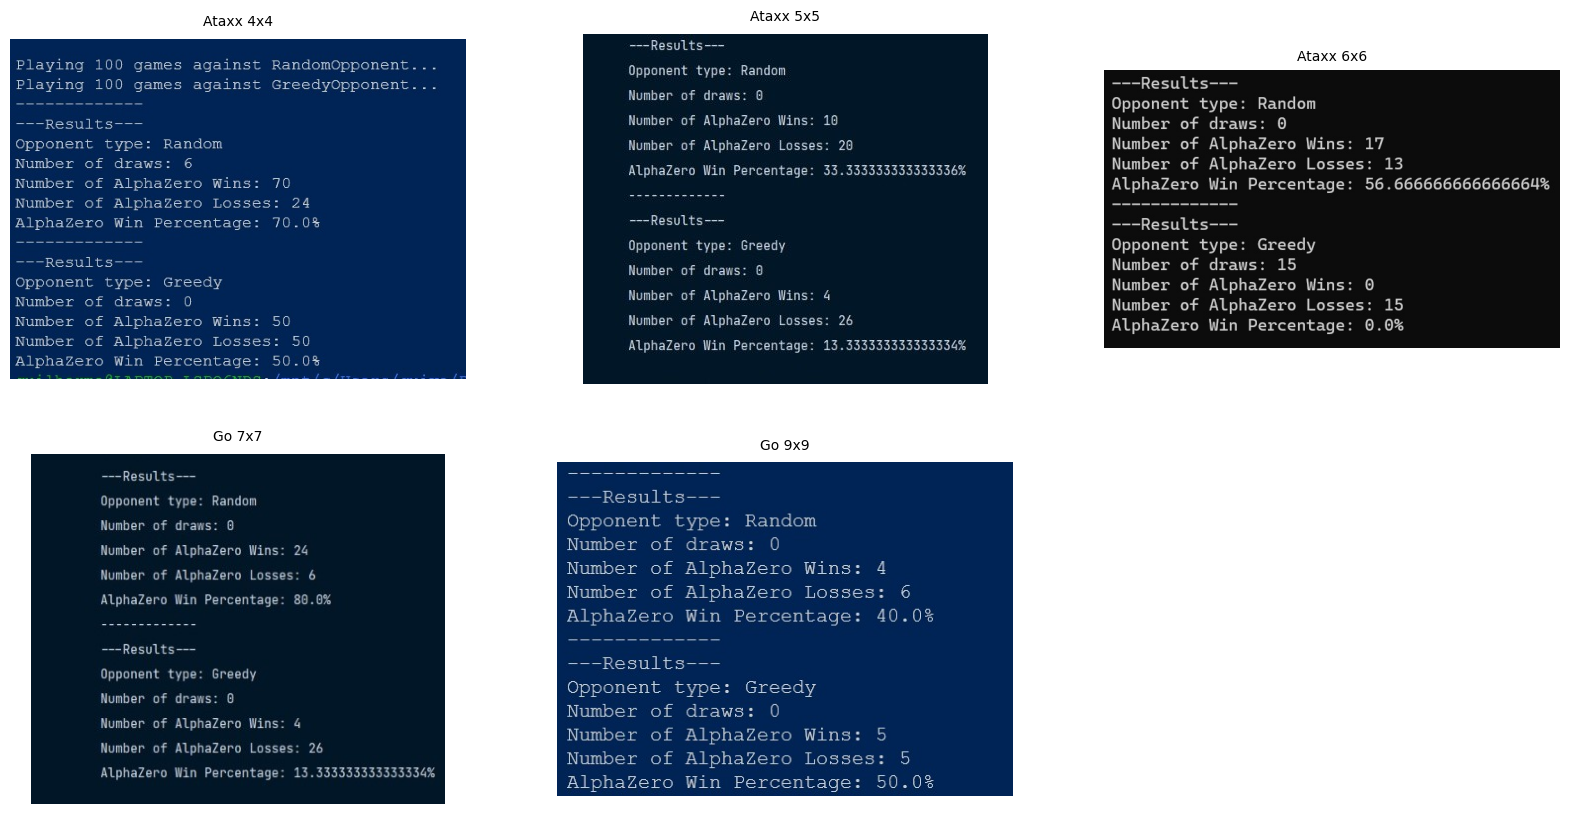

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

rcParams['figure.figsize'] = 20, 10  # Ajuste o tamanho da figura conforme necessário

img_A = mpimg.imread('attax4x4.jfif')
img_B = mpimg.imread('attax5x5.jfif')
img_C = mpimg.imread('attax6x6.jfif')
img_D = mpimg.imread('go7x7.jfif')
img_E = mpimg.imread('go9x9.jfif')

fig, ax = plt.subplots(2, 3)  # 2 linhas, 3 colunas

ax[0, 0].imshow(img_A)
ax[0, 0].text(0.5, 1.05, 'Ataxx 4x4', ha='center', va='center', transform=ax[0, 0].transAxes)

ax[0, 1].imshow(img_B)
ax[0, 1].text(0.5, 1.05, 'Ataxx 5x5', ha='center', va='center', transform=ax[0, 1].transAxes)

ax[0, 2].imshow(img_C)
ax[0, 2].text(0.5, 1.05, 'Ataxx 6x6', ha='center', va='center', transform=ax[0, 2].transAxes)

ax[1, 0].imshow(img_D)
ax[1, 0].text(0.5, 1.05, 'Go 7x7', ha='center', va='center', transform=ax[1, 0].transAxes)

ax[1, 1].imshow(img_E)
ax[1, 1].text(0.5, 1.05, 'Go 9x9', ha='center', va='center', transform=ax[1, 1].transAxes)

for a in ax.flatten():
    a.axis('off')

plt.show()

## Cliente

In [ ]:
import socket
import time
import numpy as np
from attaxx.attaxx import Attaxx
from go_pygame.go_1 import Go
from alphazero import MCTS
import torch
from alphazero import ResNet
from args_manager import load_args_from_json

# Game = "A4x4"
# Game = "A5x5"
# Game = "A6x6"
# Game = "G7x7"
Game = "G9x9"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#####################################################
# falta por para diferentes tamanhos e fazer para o go
#####################################################

def prepair_model(sizeBoard):

    global game, mcts, model, args, state

    if Game[0]=="A": #jogo ataxx
        if sizeBoard ==4:
            game=Attaxx([int(Game[-1]),int(Game[-1])])
            model_name = "Attaxx_try1"
            args=load_args_from_json(f'AlphaZero/Models/{model_name}', Attaxx, model_name)
            model = ResNet(game, 9, 64, device)
            mcts = MCTS(model, game, args)
            model.load_state_dict(torch.load(f'AlphaZero/Models/{model_name}/model.pt', map_location=device))
            #optimizer.load_state_dict(torch.load(f'AlphaZero/Models/Attax_TestModel/optimizer_4.pt', map_location=device))
            state = game.get_initial_state()
            return state,mcts,game

        # if sizeBoard ==5:
        #     game=Attaxx([int(Game[-1]),int(Game[-1])])
        #     model_name = "Attaxx_try1"
        #     args=load_args_from_json(f'AlphaZero/Models/{model_name}', Attaxx, model_name)
        #     model = ResNet(game, 9, 64, device)
        #     mcts = MCTS(model, game, args)
        #     model.load_state_dict(torch.load(f'AlphaZero/Models/{model_name}/model.pt', map_location=device))
        #     #optimizer.load_state_dict(torch.load(f'AlphaZero/Models/Attax_TestModel/optimizer_4.pt', map_location=device))
        #     state = game.get_initial_state()
        #     return state,mcts,game

        # if sizeBoard ==6:
        #     game=Attaxx([int(Game[-1]),int(Game[-1])])
        #     model_name = "Attaxx_try1"
        #     args=load_args_from_json(f'AlphaZero/Models/{model_name}', Attaxx, model_name)
        #     model = ResNet(game, 9, 64, device)
        #     mcts = MCTS(model, game, args)
        #     model.load_state_dict(torch.load(f'AlphaZero/Models/{model_name}/model.pt', map_location=device))
        #     #optimizer.load_state_dict(torch.load(f'AlphaZero/Models/Attax_TestModel/optimizer_4.pt', map_location=device))
        #     state = game.get_initial_state()

        #     return state,mcts,game

    else:
        # if sizeBoard == 7:
        #     go_game = Go(board_size)
        #     model_name = "Go_go91"
        #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #     model = ResNet(game, 9, 64, device)
        #     model.load_state_dict(torch.load(f'AlphaZero/Models/{model_name}/model.pt', map_location=device))
        #     args=load_args_from_json(f'AlphaZero/Models/{model_name}', "Go", model_name)
        #     #optimizer.load_state_dict(torch.load(f'AlphaZero/Models/Attax_TestModel/optimizer_4.pt', map_location=device))
        #     mcts = MCTS(model, game, args)
        #     return state,mcts,game

        if sizeBoard == 9:
            game = Go(False)
            model_name = "Go_go91"
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = ResNet(game, 9, 64, device)
            model.load_state_dict(torch.load(f'AlphaZero/Models/{model_name}/model.pt', map_location=device))
            args=load_args_from_json(f'AlphaZero/Models/{model_name}', "Go", model_name)
            #optimizer.load_state_dict(torch.load(f'AlphaZero/Models/Attax_TestModel/optimizer_4.pt', map_location=device))
            mcts = MCTS(model, game, args)
            state = game.get_initial_state()
            return state,mcts,game



def generate_move(state,mcts,game, ag):


    if Game[0] == "A":
        #neut = game.change_perspective(state, -ag)
        action = mcts.search(state,  ag)
        action = np.argmax(action)
        move=game.int_to_move(action)
        state = game.get_next_state(state, action, ag)
        return f"MOVE {move[0]} {move[1]} {move[2]} {move[3]}", state

    else:
        #neut = game.change_perspective(state, -ag)
        action = mcts.search(state, ag)
        action = np.argmax(action)
        x,y = game.int_to_move_go(action)
        state = game.get_next_state_mcts(state, action, ag)
        return f"MOVE {x} {y}" , state


def movimento_adversario(respostaServidor, state,ag):

    if Game[0] =="A":
        resposta = respostaServidor.split()
        #print(resposta)

        movimentos = [int(r) for r in resposta[1:]]
        #print(movimentos)
        sizeBoard = int(Game[-1])
        #print("Size board = " , sizeBoard)
        #print(respostaServidor)
        action = movimentos[3] +  movimentos[2] *  sizeBoard +  movimentos[1] *  sizeBoard ** 2 +  movimentos[0] *  sizeBoard ** 3
        state_new = game.get_next_state(state, action, -ag)
        return state_new
    else:
        resposta = respostaServidor.split()
        movimentos = [int(r) for r in resposta[1:]]
        #print(movimentos)
        sizeBoard = int(Game[-1])
        #print(resposta, " : resposta ")
        action=movimentos[0] + movimentos[1] * sizeBoard
        #print(action, ": action")
        state_new = game.get_next_state(state, action, -ag)
        return state_new

def connect_to_server(host='localhost', port=12345):
    global ag
    client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client_socket.connect((host, port))

    response = client_socket.recv(1024).decode()
    print(f"Server ResponseINIT: {response}")
    Game = response[-4:]
    print("Playing:", Game)

    #print("response[2] = ", response[2] )
    if response[2] == "1":
        ag=1
    else:
        ag=-1
    first=True

    state, mcts, game = prepair_model(Game[-1])

    while True:
        # Generate and send a random move
        #print("entrou")
        if ag == 1 or not first:
               # print("entrou aqui ")
                print("state = \n" , state)

                move,state = generate_move(state, mcts,game, ag)
                #print(state)
                time.sleep(1)
                client_socket.send(move.encode())
                #print("\nSend:",move)

                # Wait for server response
                response = client_socket.recv(1024).decode()
                print(f"Server Response1: {response}")
                if "END" in response: break

                # while response == 'INVALID':
                #     print("Invalid Move")
                #     move = generate_move(state, mcts,game, ag)
                #     time.sleep(1)
                #     client_socket.send(move.encode())
                #     print("Send:",move)
                #     response = client_socket.recv(1024).decode()
                #     print(f"Server Response1: {response}")

        first=False
        response = client_socket.recv(1024).decode()
        print(f"Server Response2: {response}")
        if "END" in response: break
        state = movimento_adversario(response, state, ag)
        # Add some condition to break the loop, if necessary
        # Example: If server sends a certain message, or after a number of moves

    client_socket.close()

if __name__ == "__main__":
    connect_to_server()


Todas as análises dos resultados e comentários acerca das decisões encontram-se no ficheiro MostImportantfeaturesG3